In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
from fooof import FOOOF
import functools
import logging
import numpy as np
import os
import quantities as pq

import epych
from epych.statistics import alignment, spectrum

/tmp/ipykernel_299843/1346669332.py:2: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF
[striatum:299843] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/2837970944/shared_mem_cuda_pool.striatum could be created.
[striatum:299843] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
EVENTS = {
    "Adapted": (ADAPTED_ONSET.magnitude, 'lightgreen'),
    "Adapted Offset": (ADAPTED_OFFSET.magnitude, 'red'),
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}
FREQ_RANGE = (spectrum.THETA_BAND[0].magnitude, spectrum.GAMMA_BAND[1].magnitude)

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]
CONDITION_TITLES = {
    "lonaive": "Local Oddball Cue Trials",
    "go_gloexp": "Global Oddball",
    "go_seqctl": "AAAA Control",
    "lo_gloexp": "Local Oddball",
    "lo_rndctl": "AAAB Random",
    "igo_seqctl": "BBBB Control"
}

In [8]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in area_titles:
        return area_titles[name]
    return name
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [9]:
def condition_stattitle(cond, name, stat):
    return stattitle(name, stat) + (" (%s)" % CONDITION_TITLES[cond])

In [10]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [11]:
summaries = {}
tfr_summaries = {}

In [12]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_spectrogram_downsample8_%s" % cond
    summaries[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram)
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


In [13]:
def oscillatory_spectrogram(spectrogram):
    spec = spectrogram.power_spectrum()
    fm = FOOOF(verbose=False, aperiodic_mode="knee")
    fm.fit(spec.freqs, spec.data.magnitude.mean(0).mean(-1), FREQ_RANGE)
    spectrogram = spectrogram.select_freqs(fm.freqs[0], fm.freqs[-1])
    aperiodic_component = fm.get_data(component='aperiodic', space='linear')
    return spectrogram.fmap(lambda data: data / (aperiodic_component[np.newaxis, np.newaxis, :, np.newaxis] * data.units))

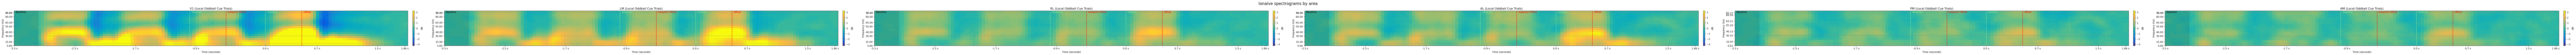

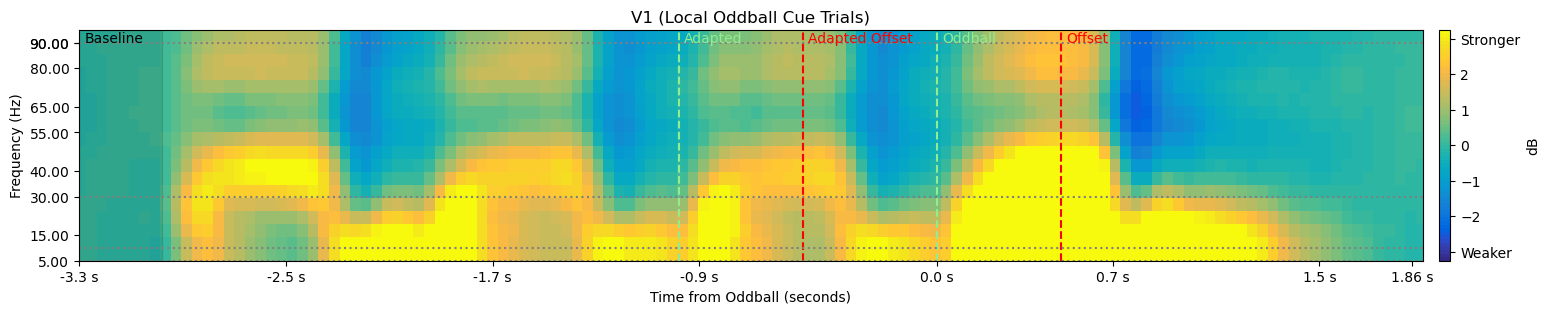

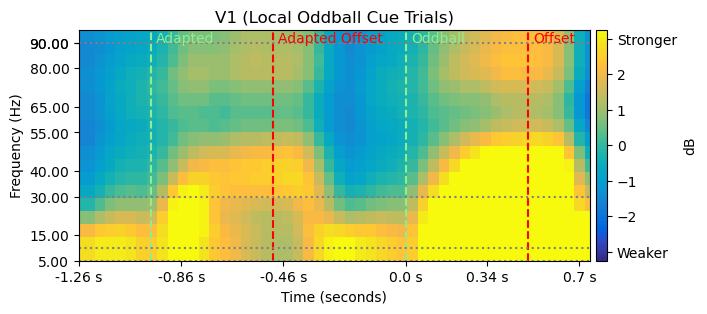

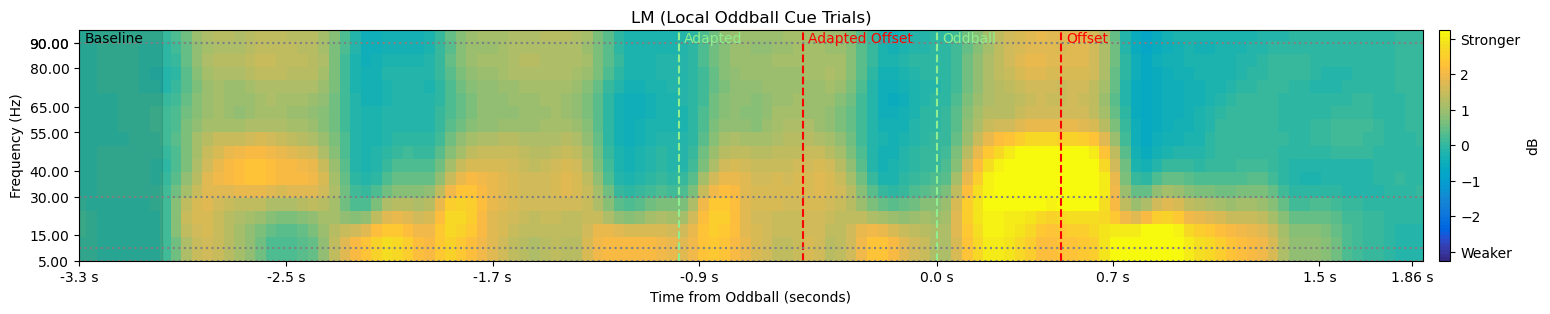

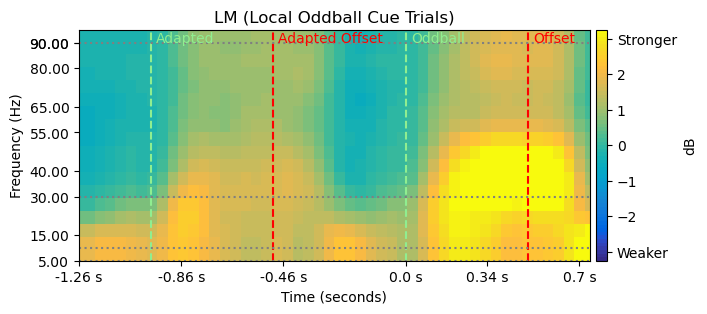

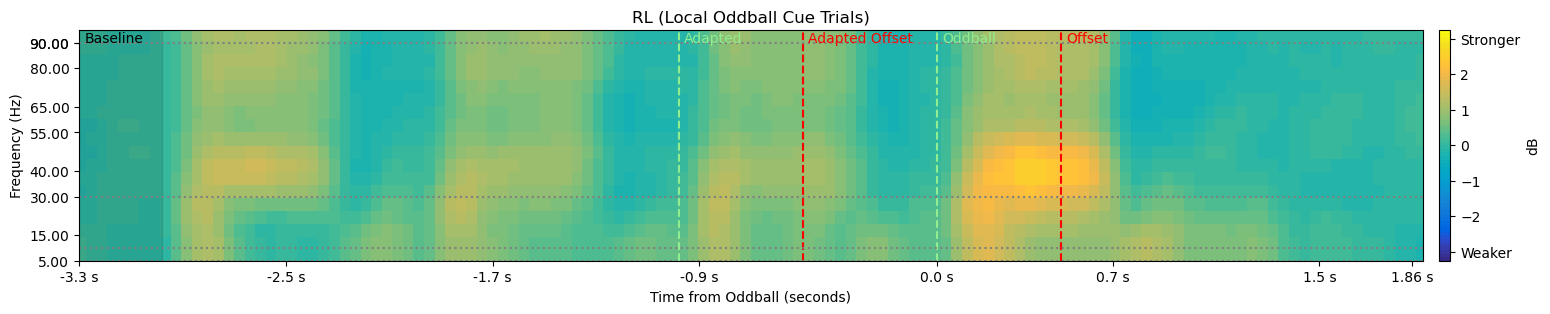

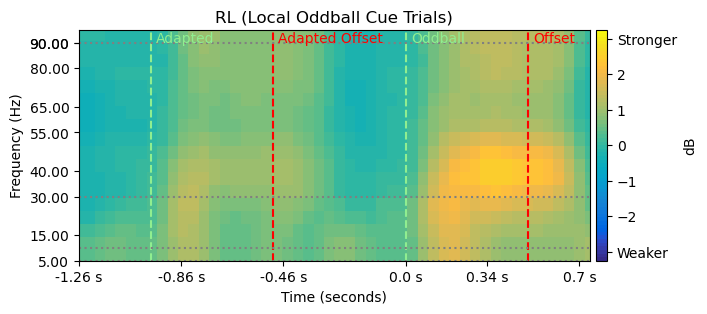

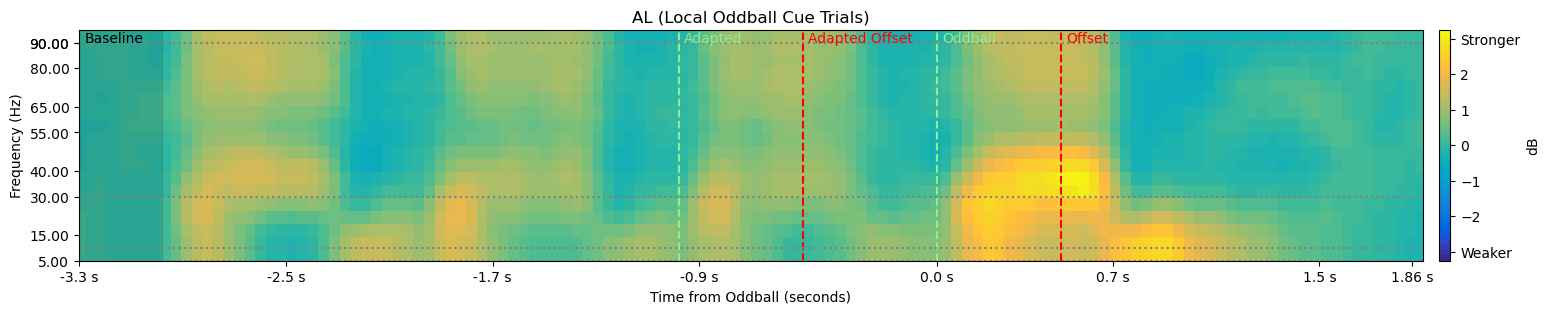

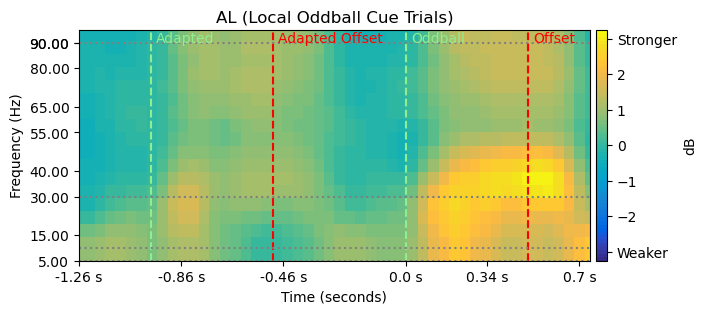

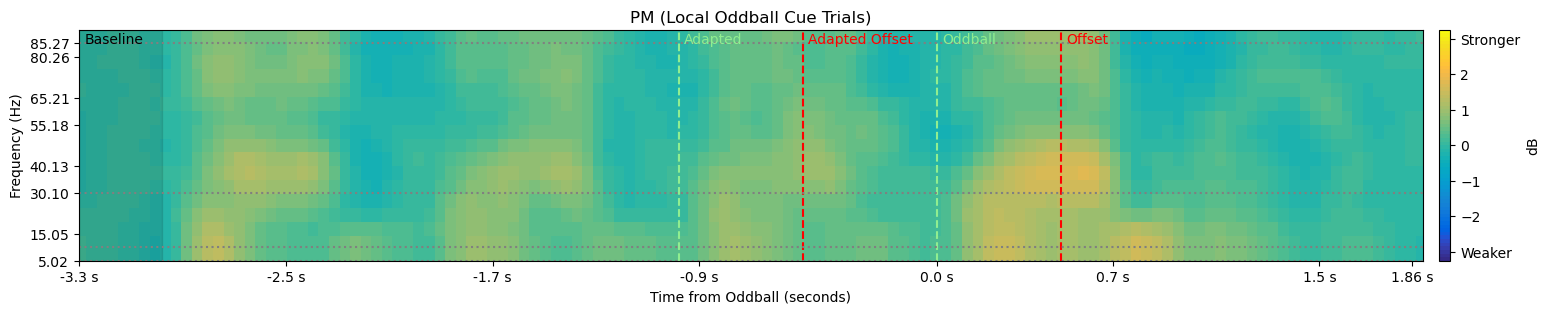

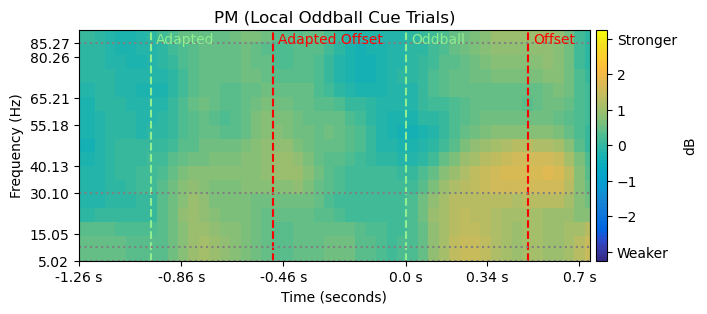

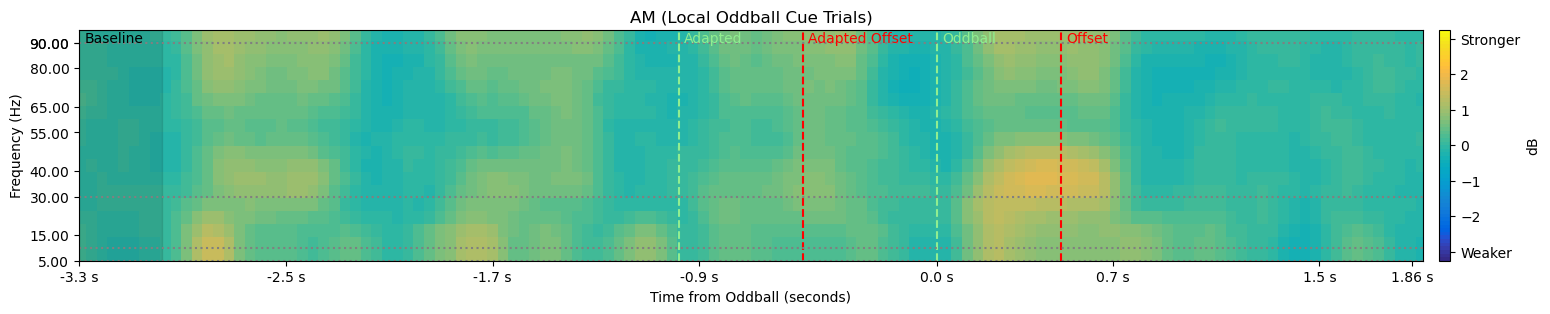

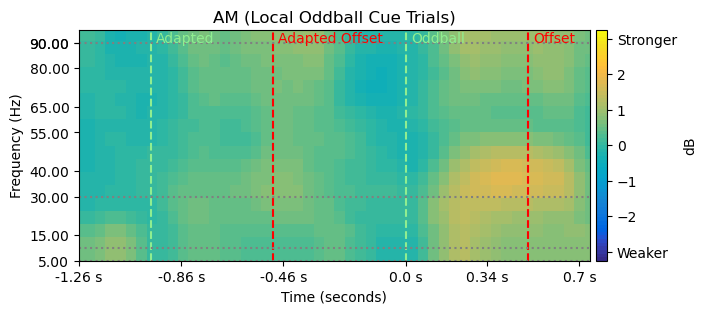

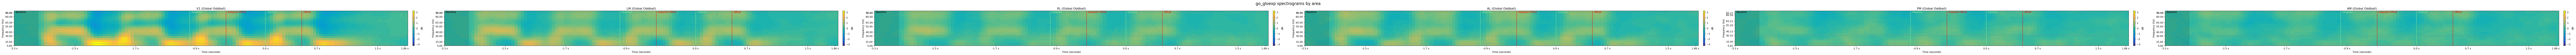

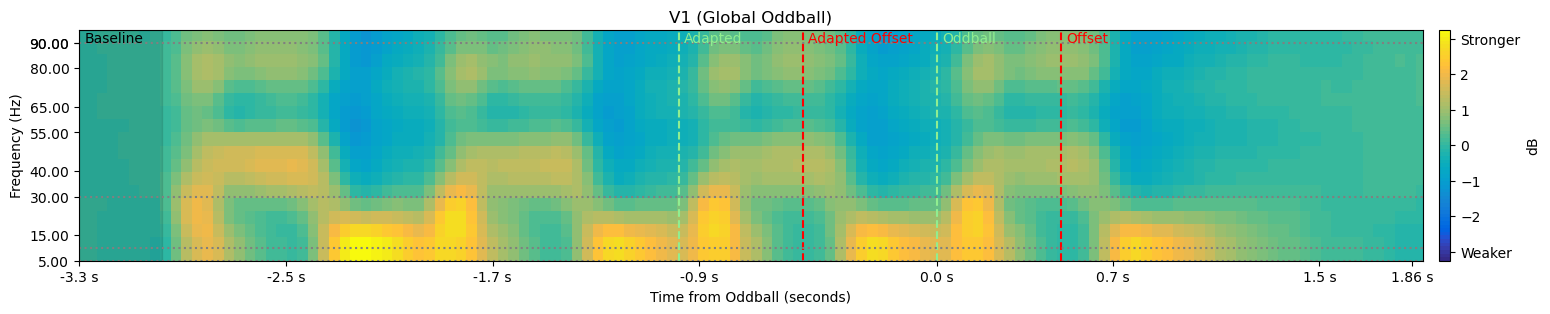

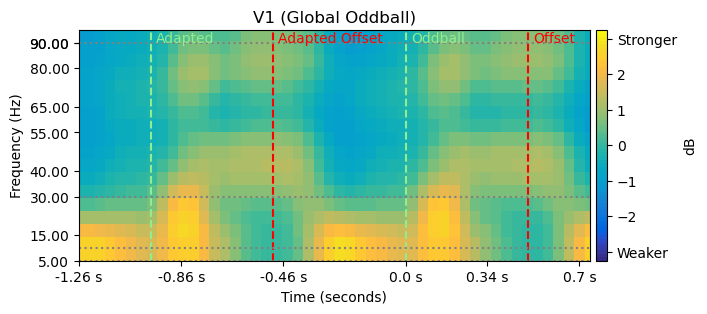

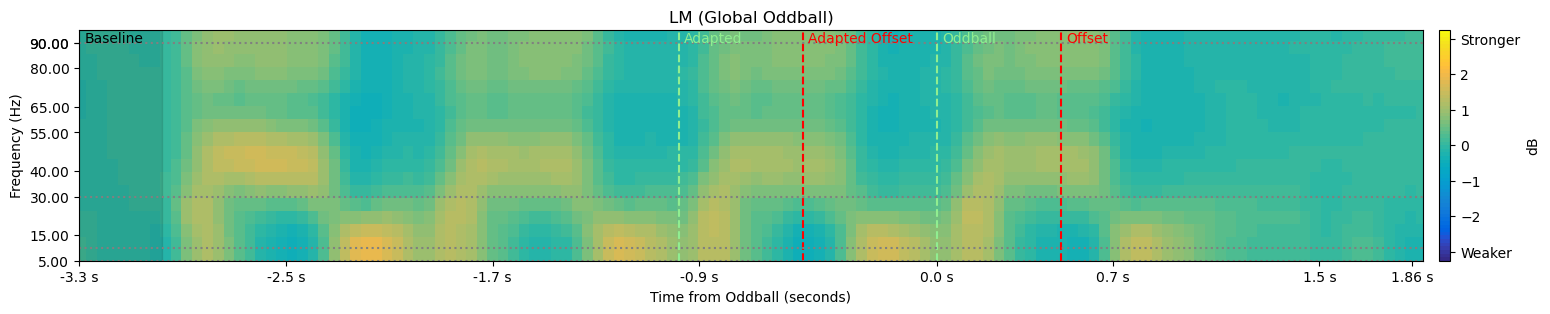

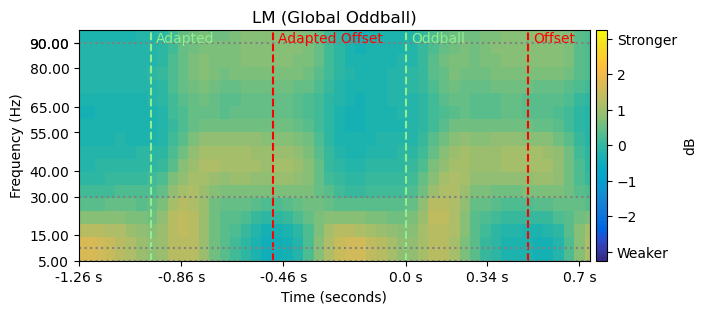

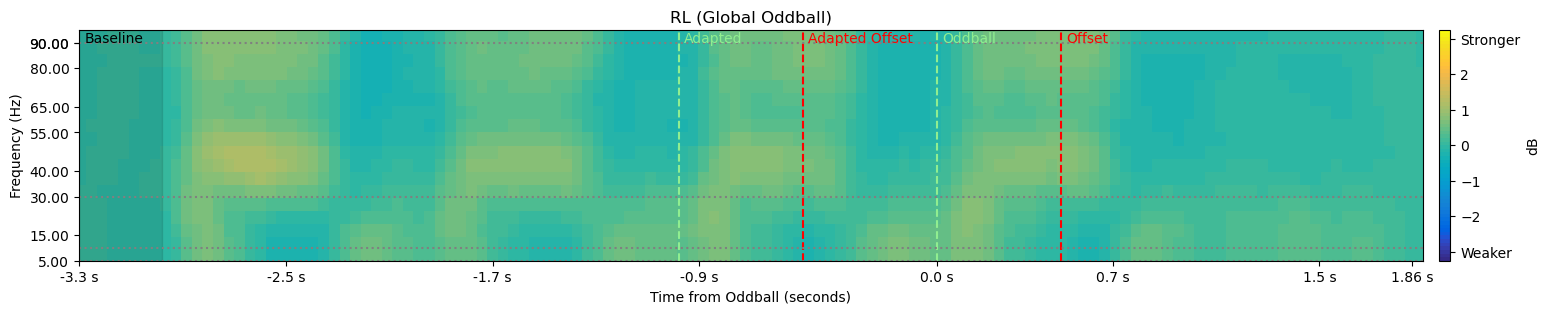

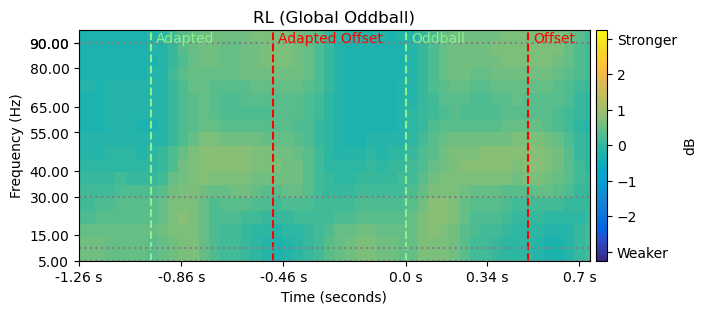

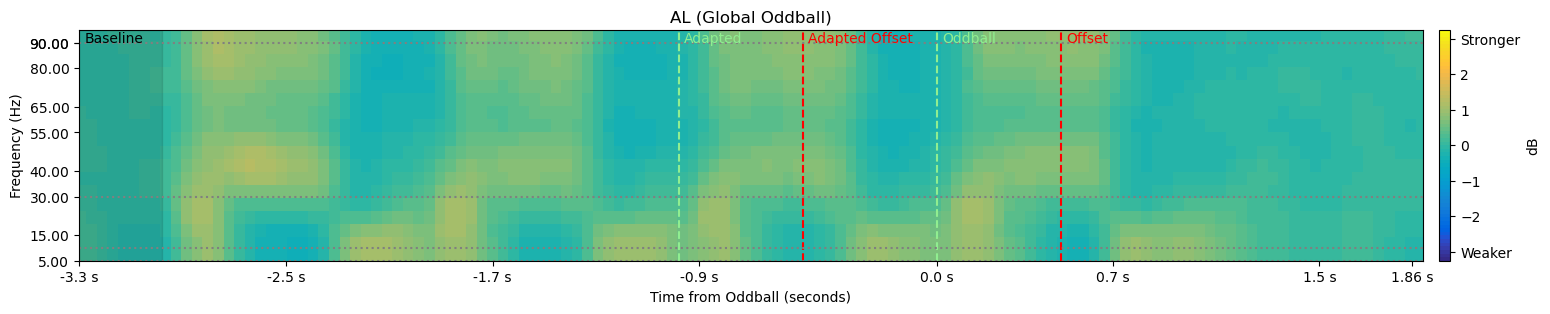

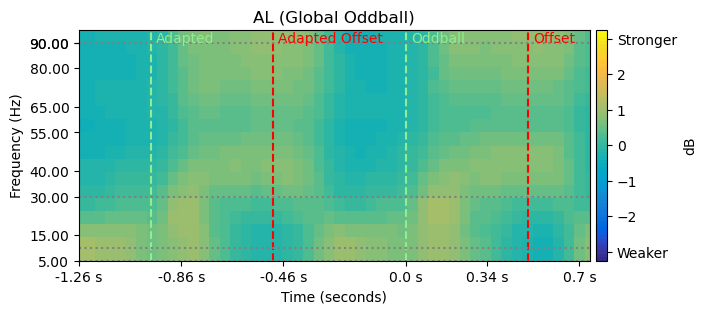

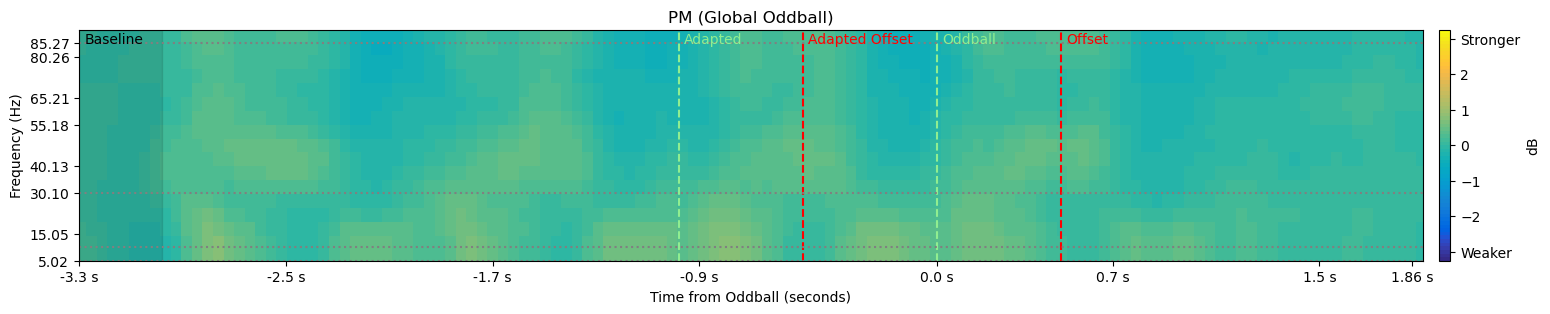

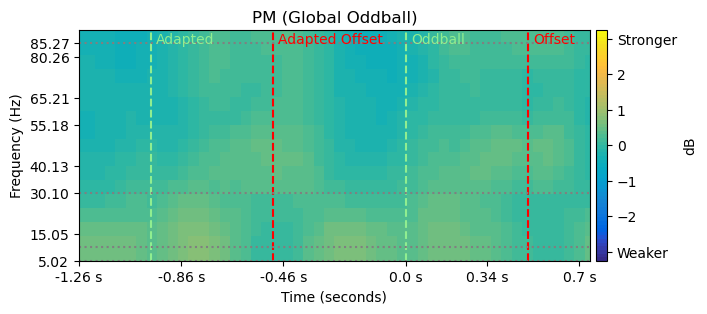

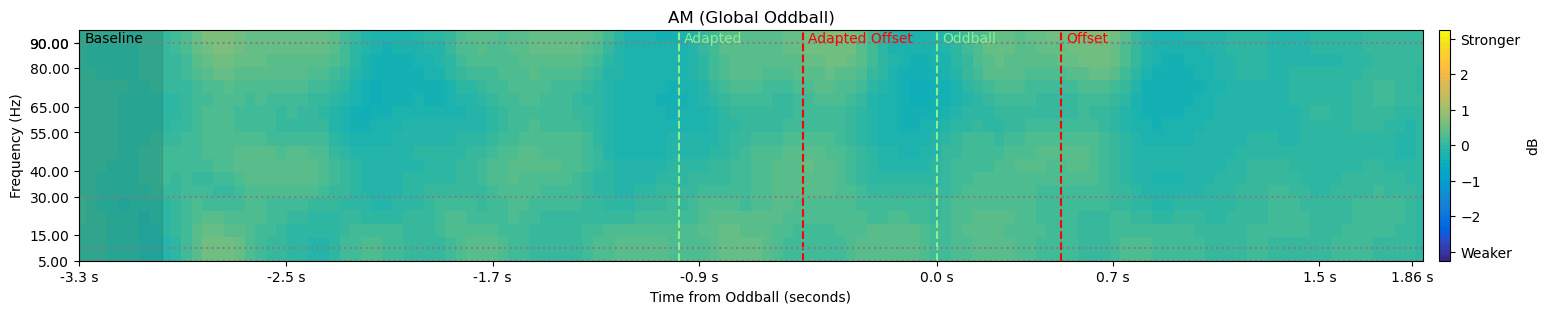

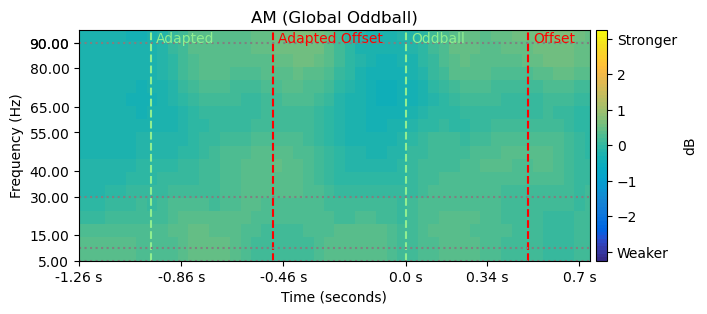

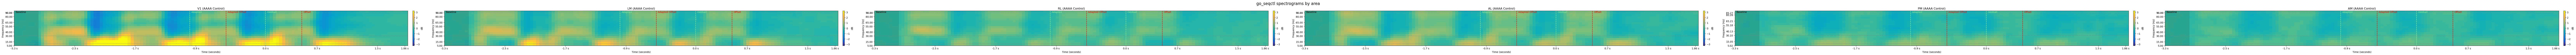

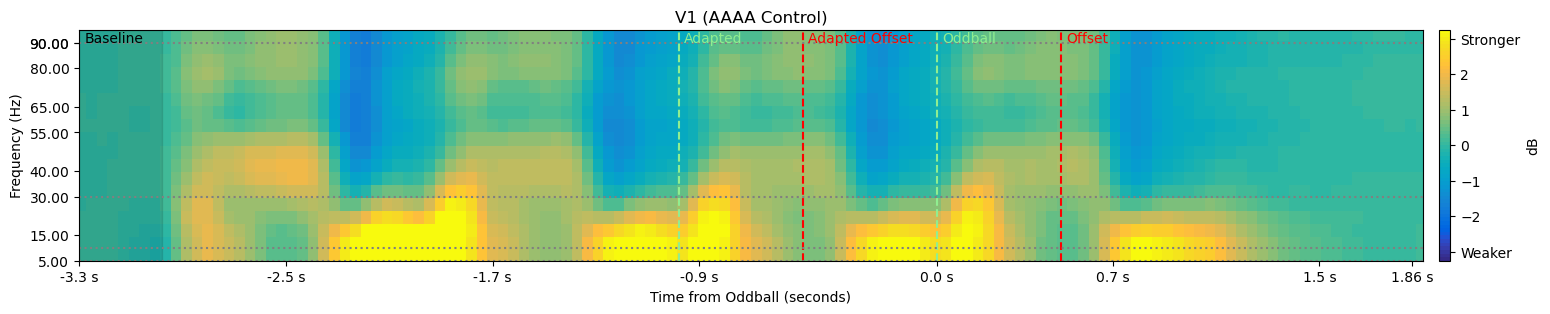

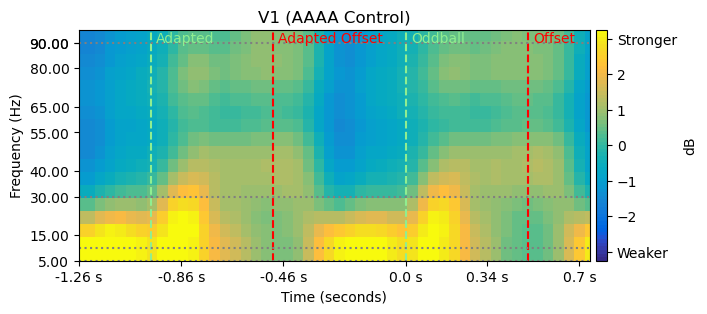

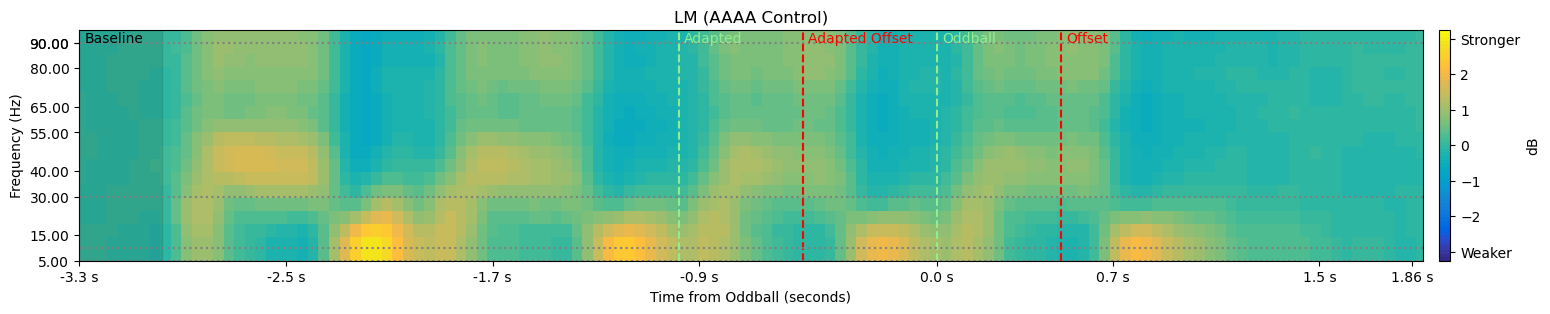

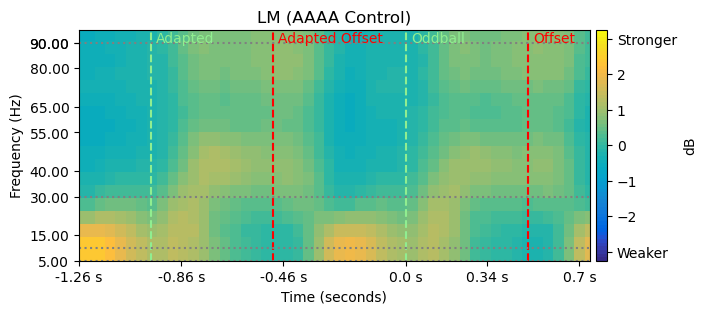

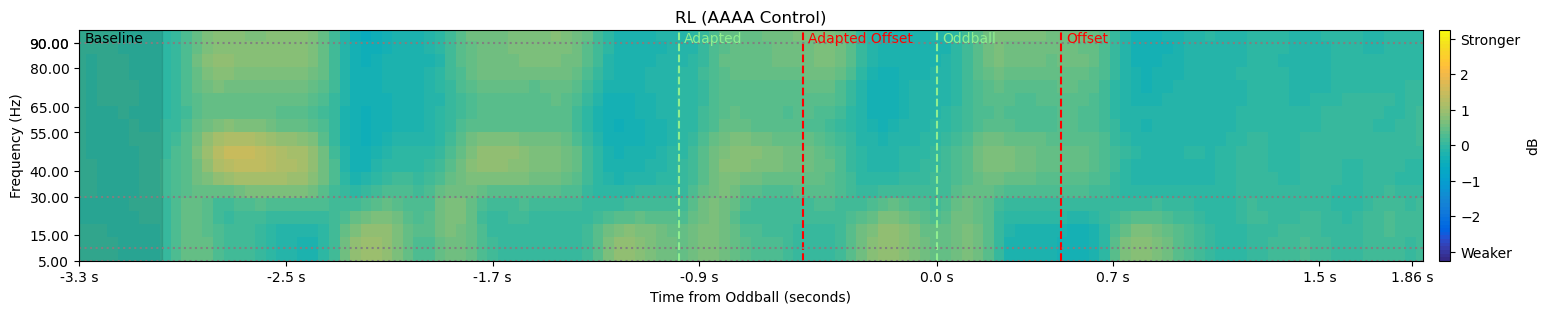

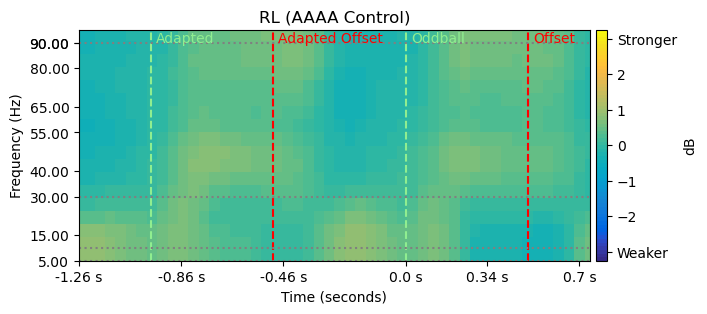

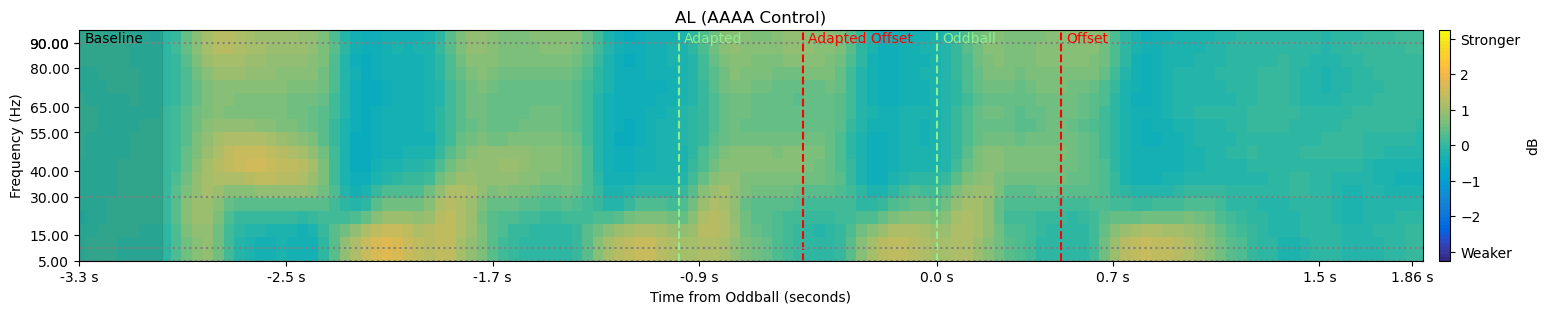

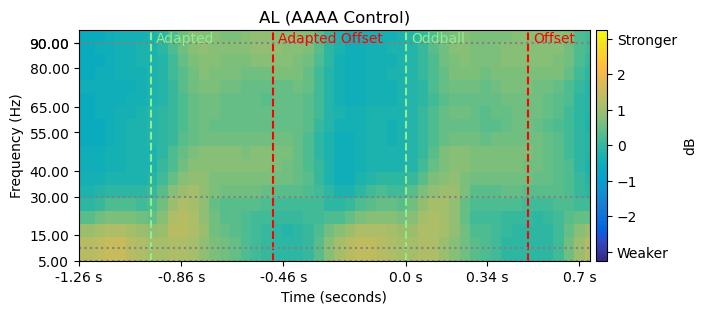

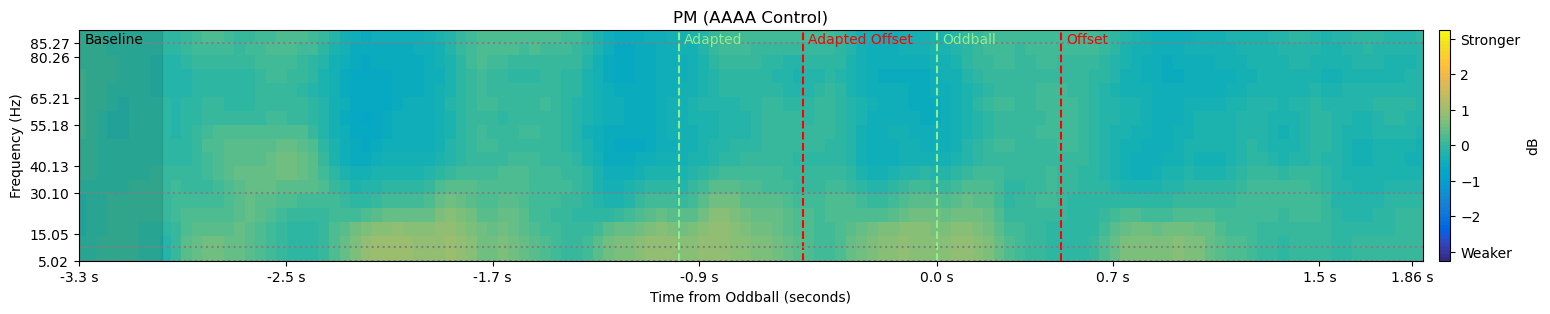

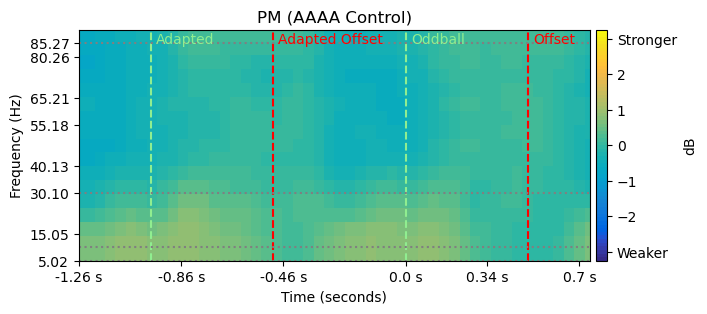

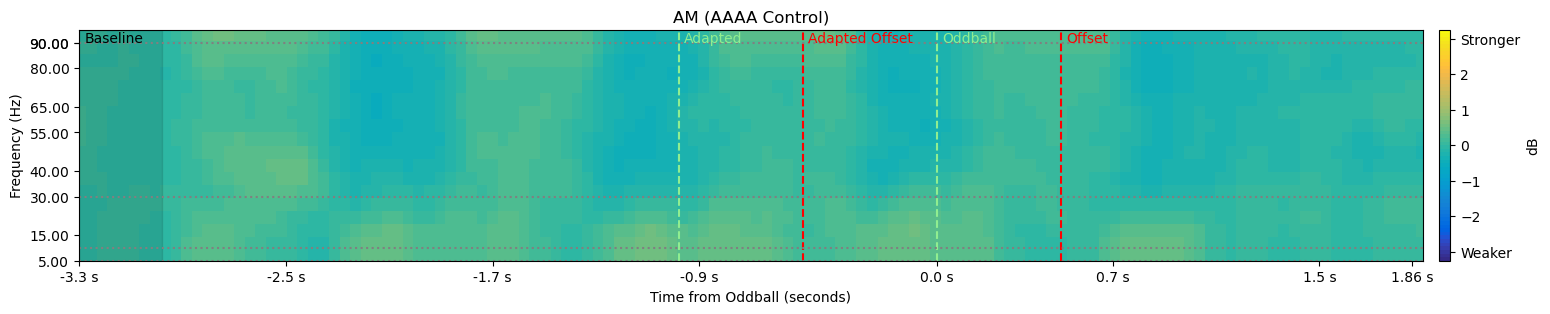

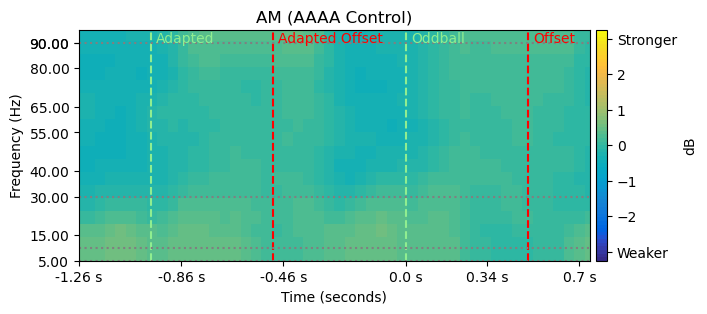

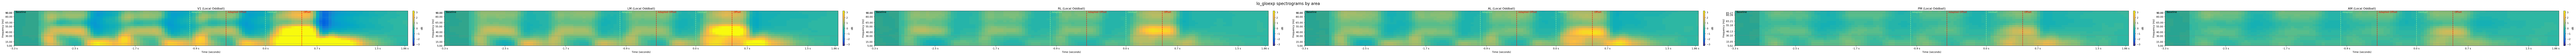

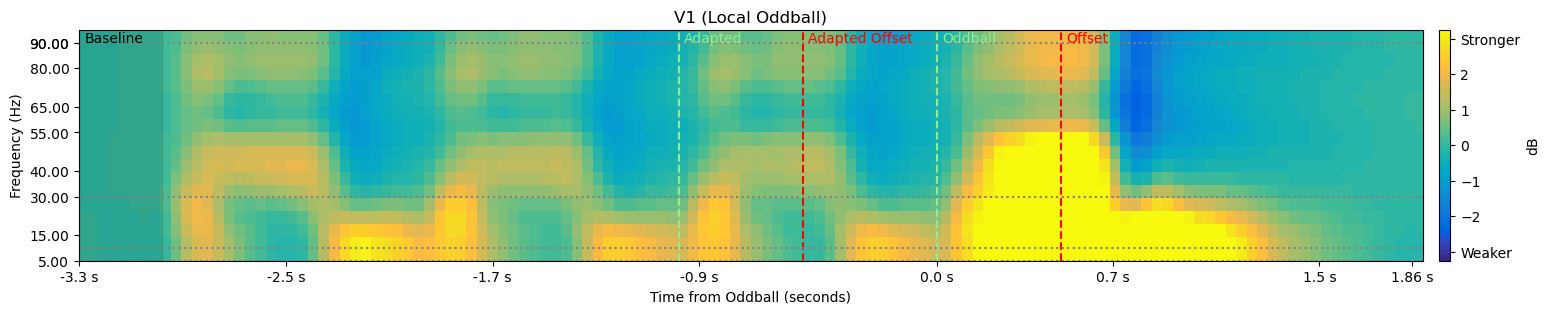

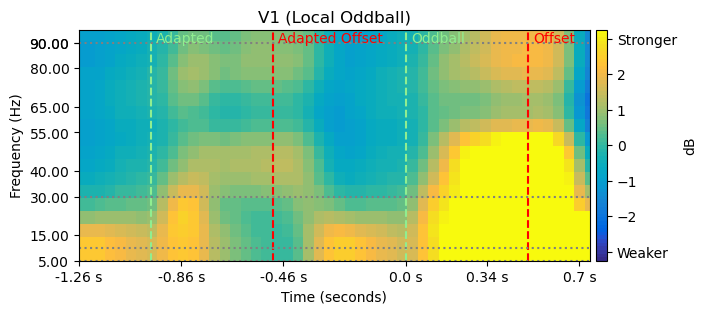

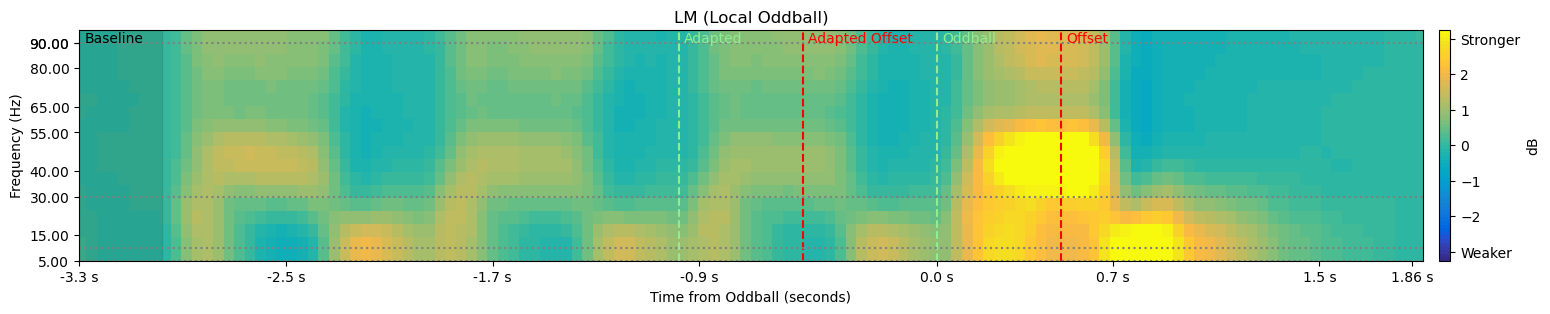

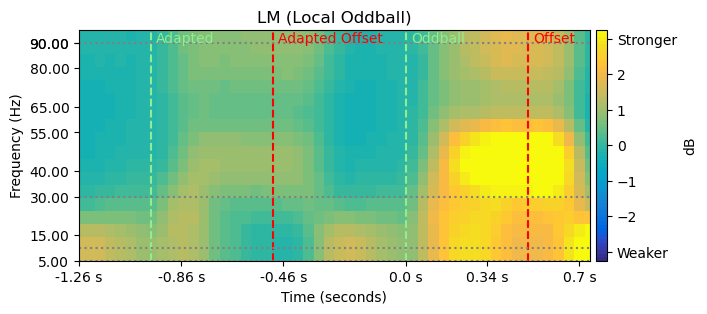

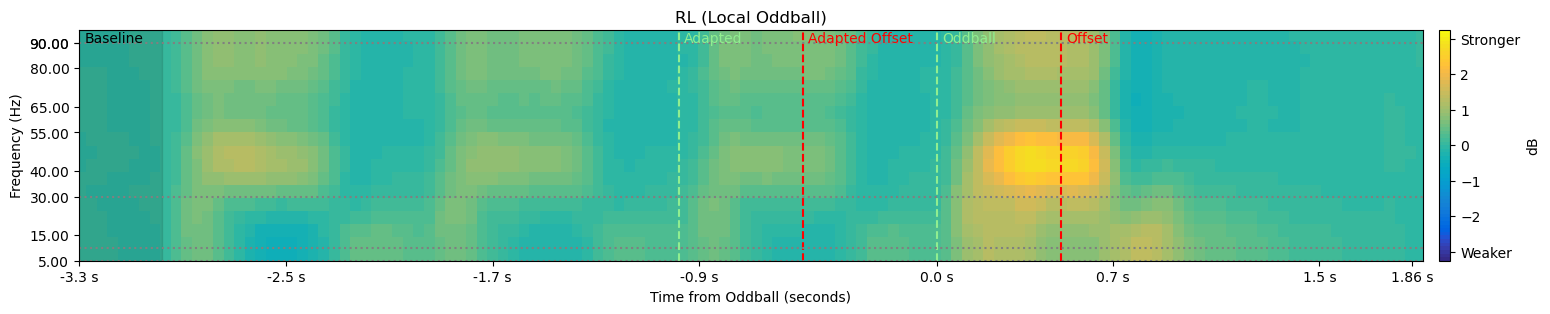

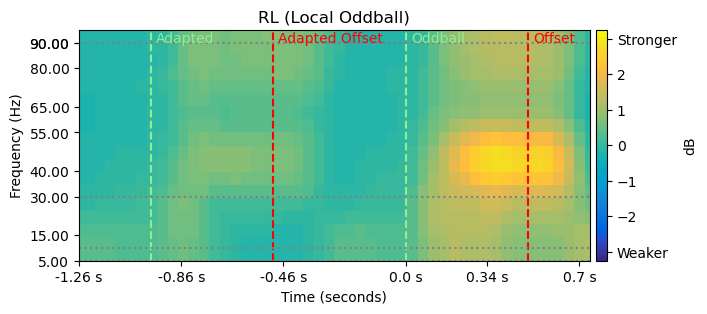

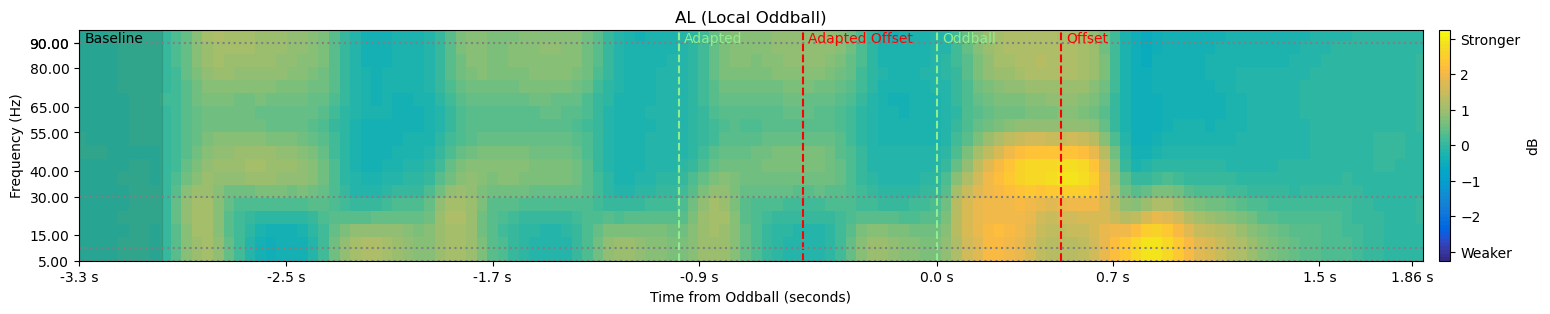

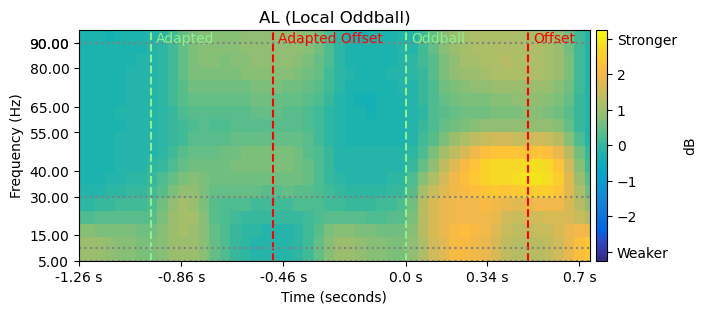

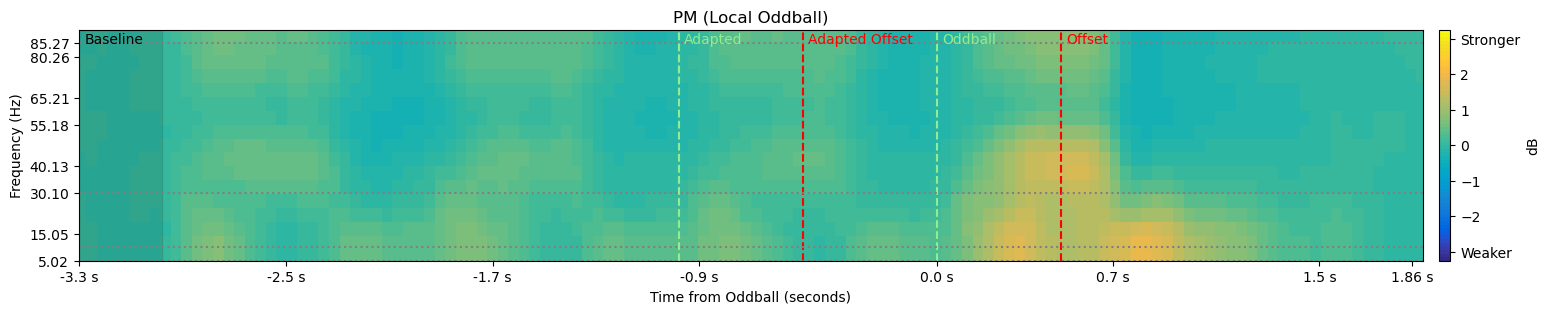

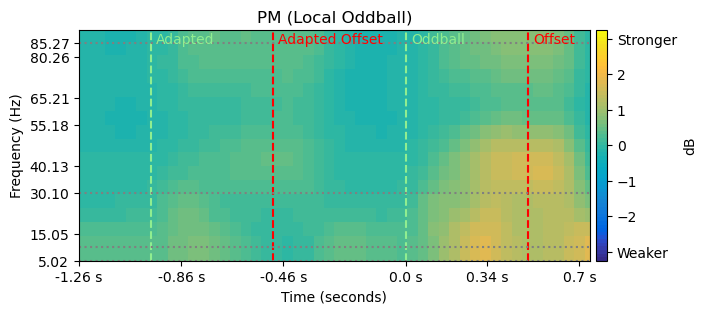

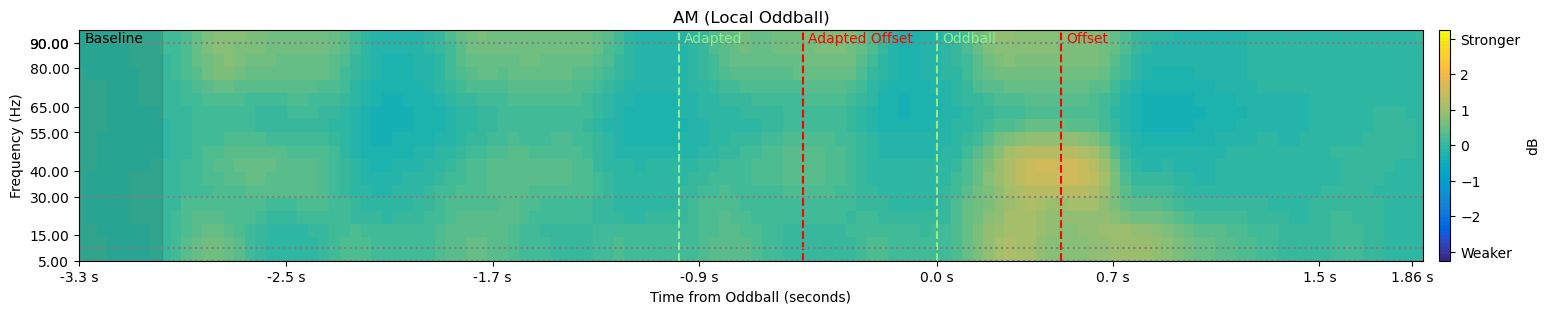

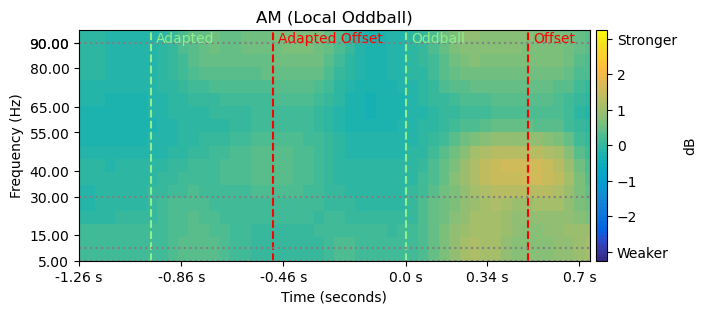

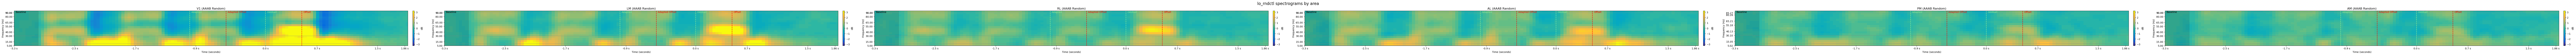

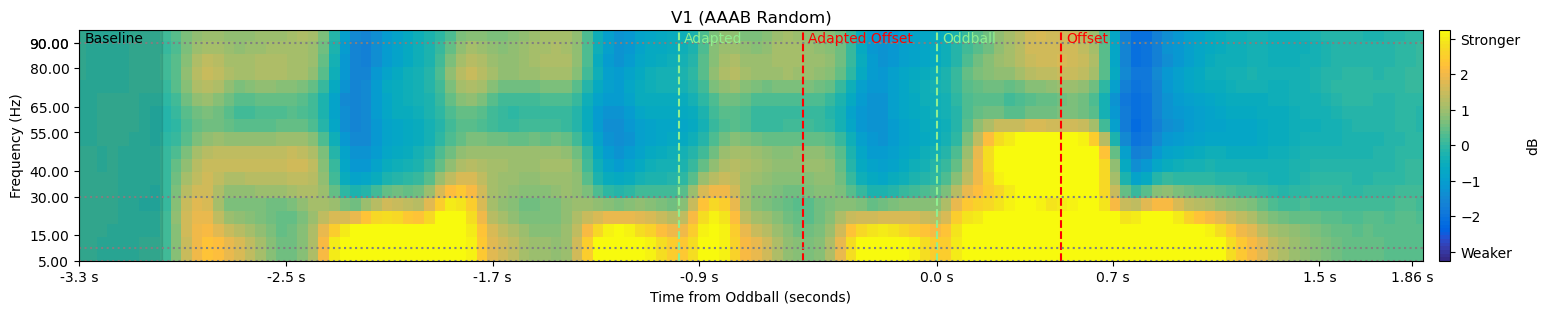

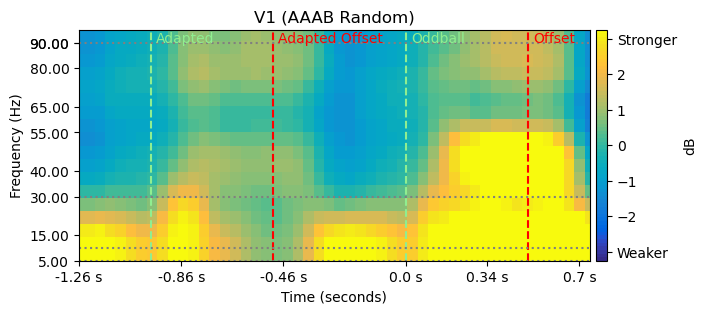

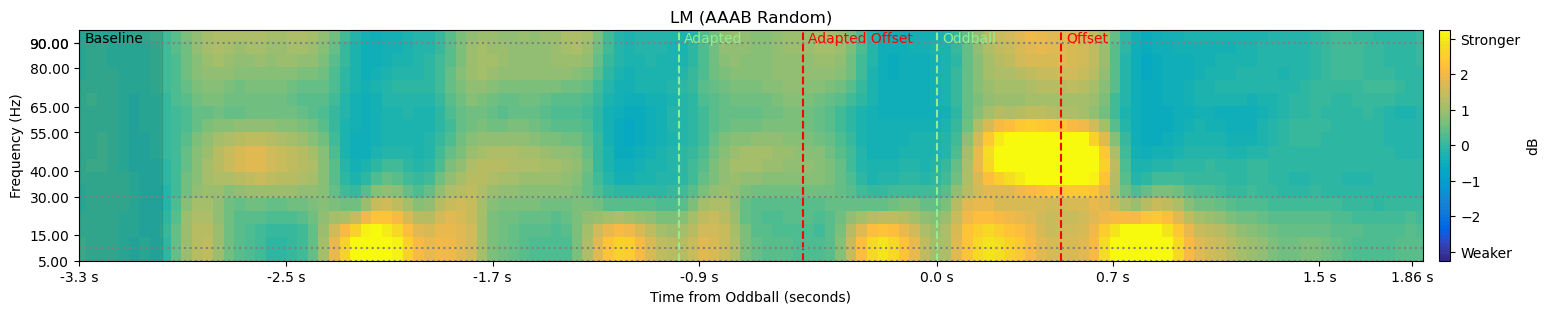

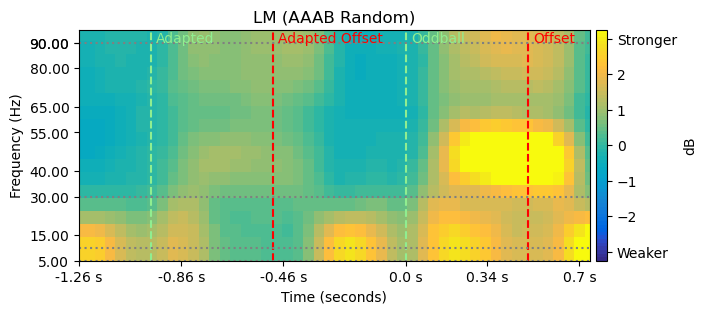

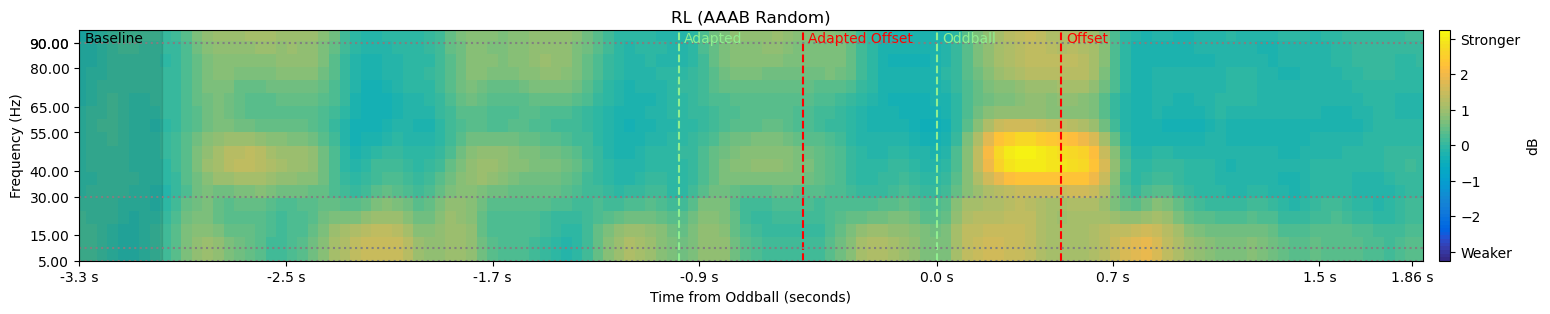

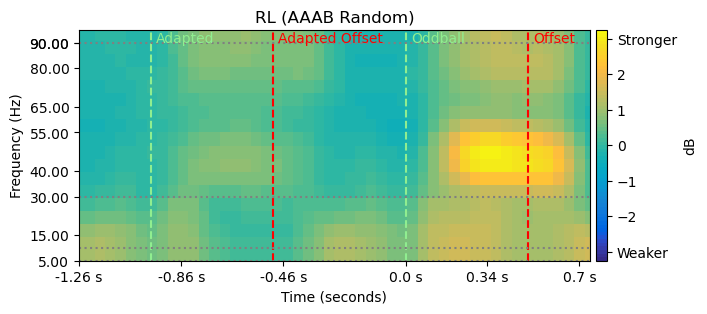

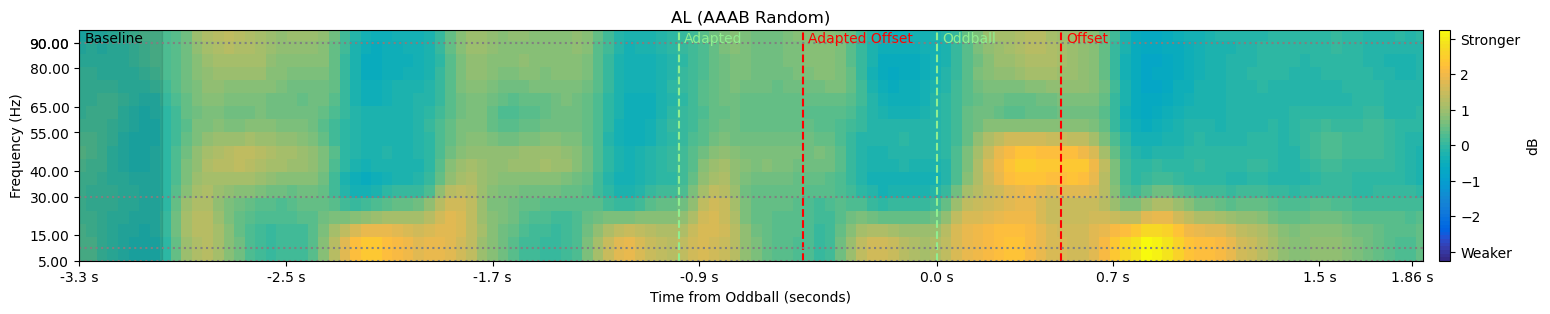

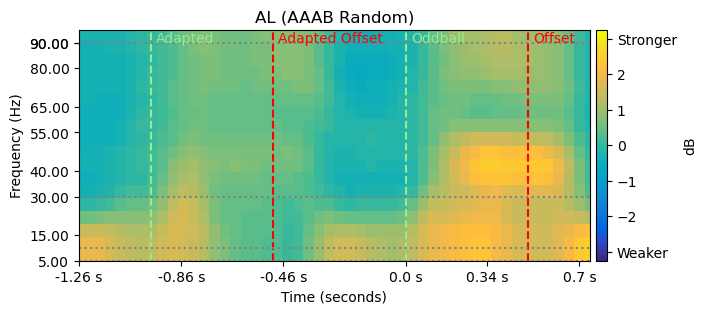

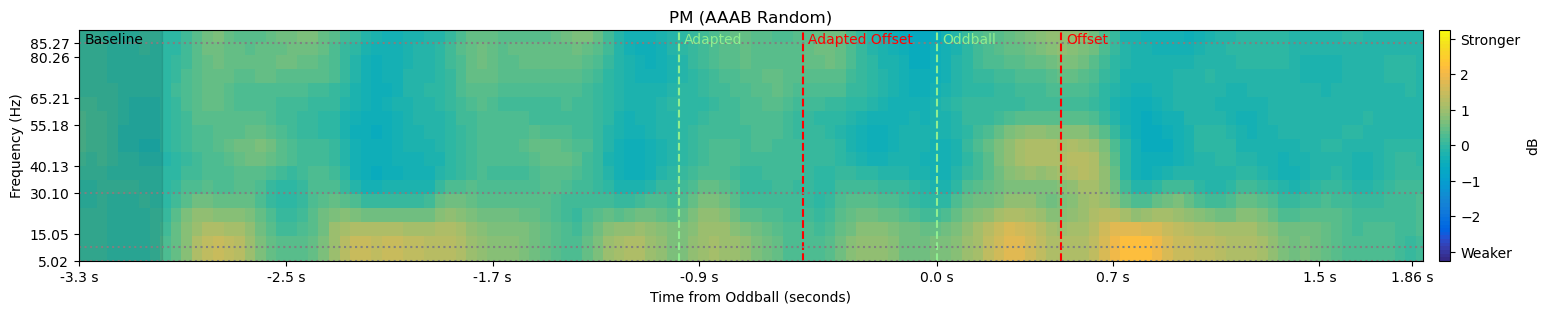

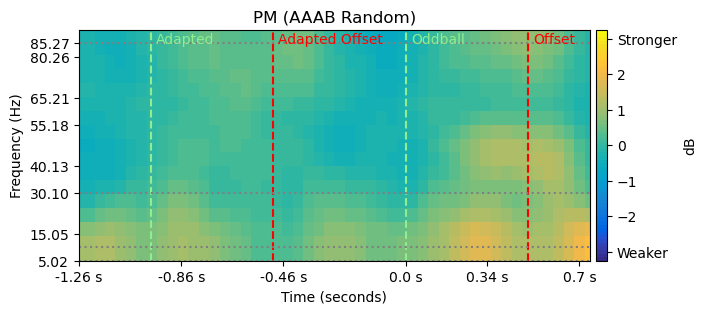

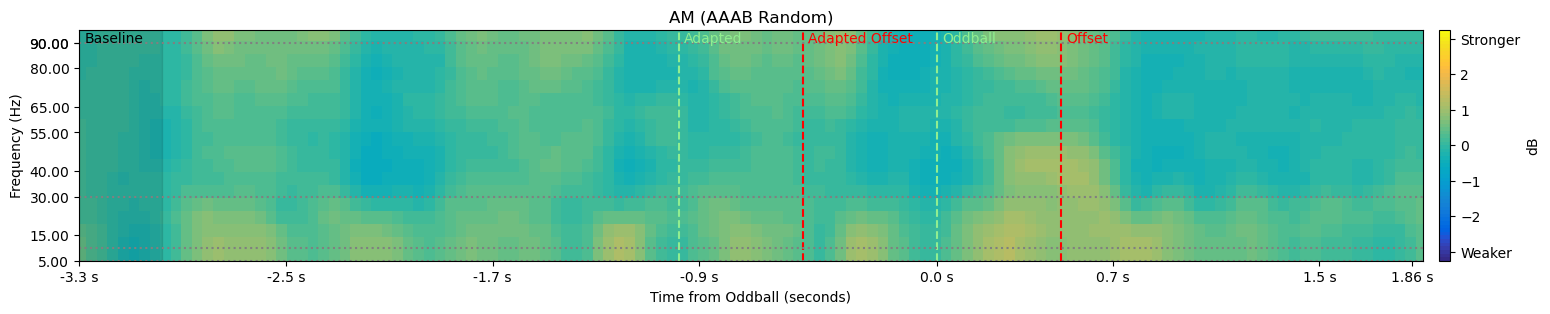

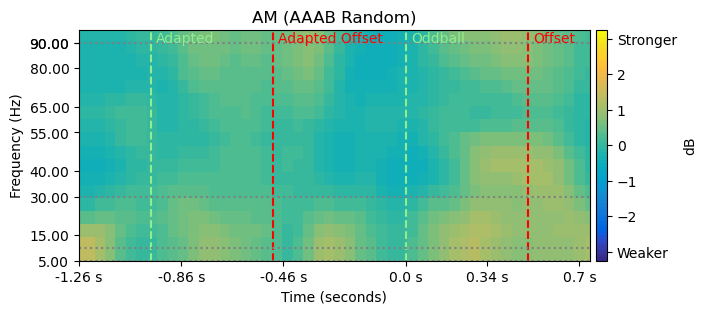

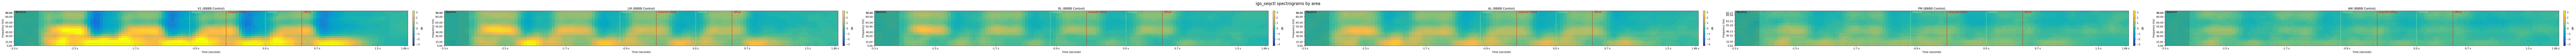

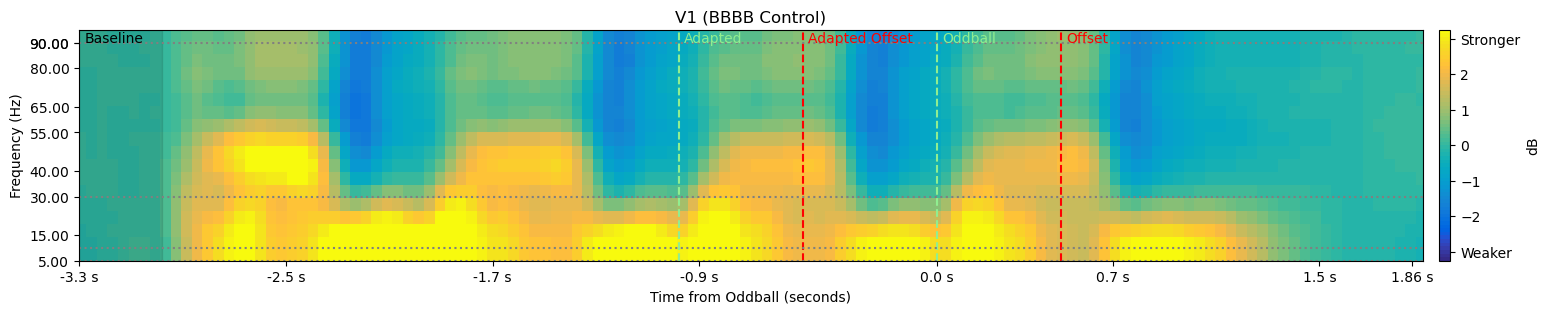

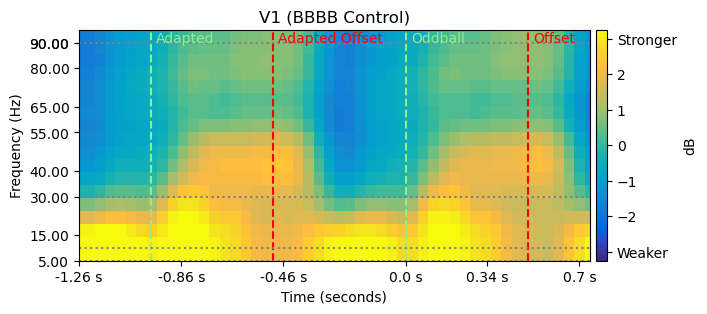

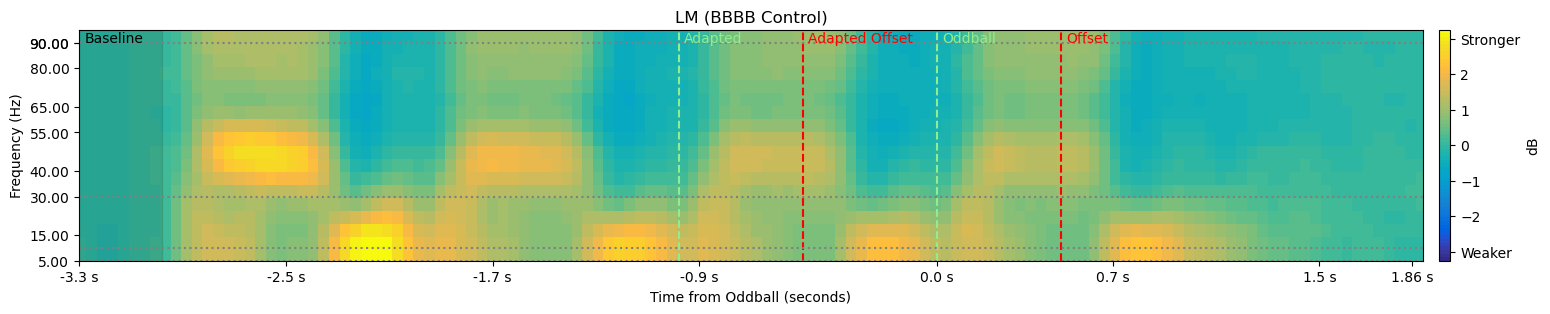

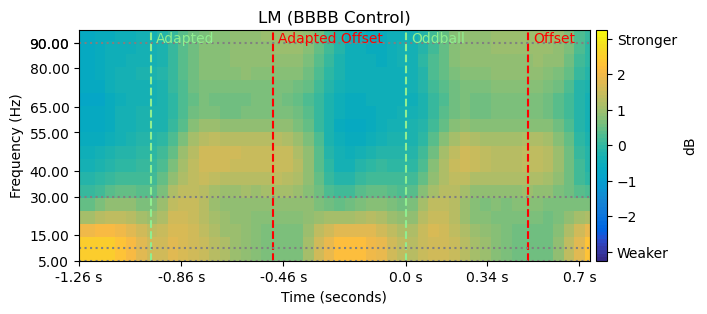

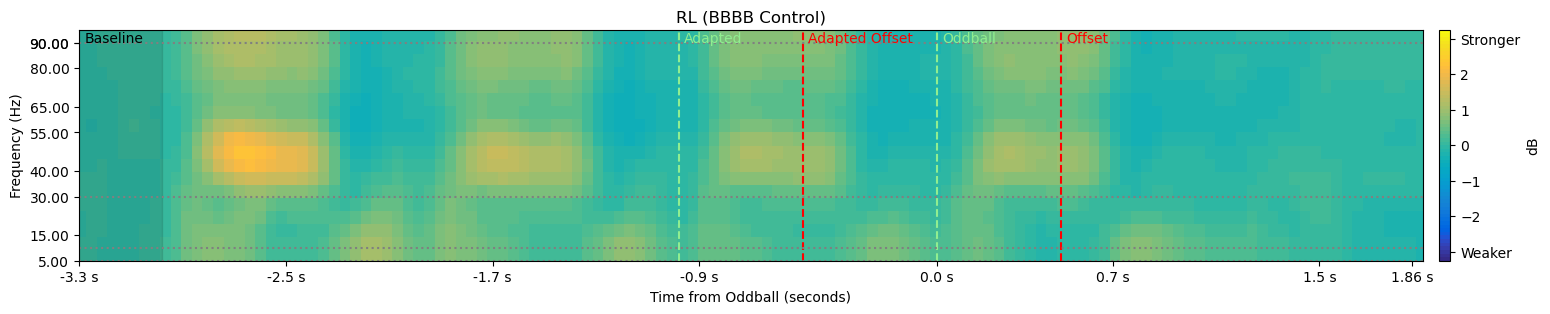

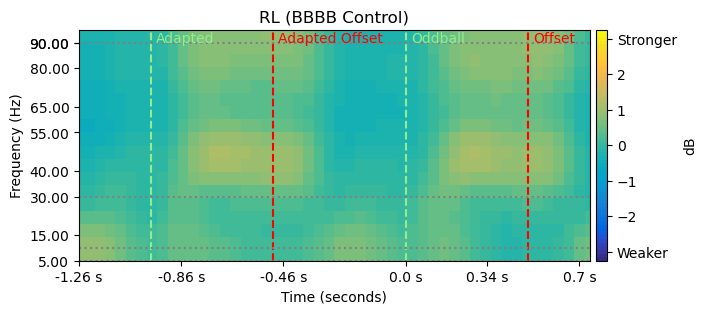

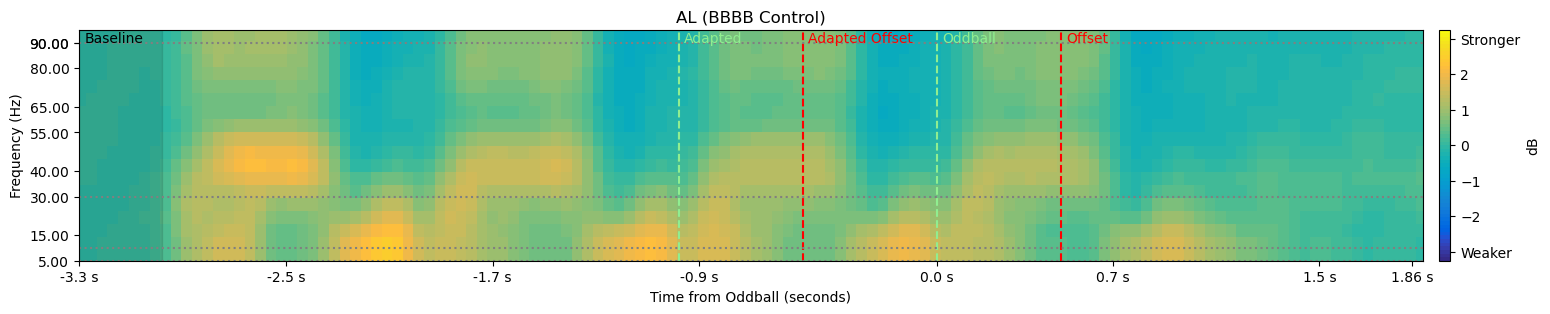

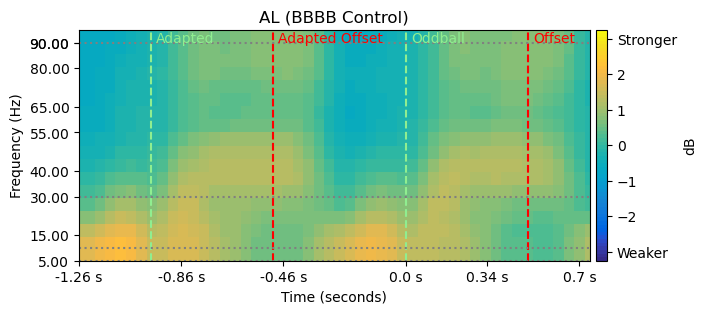

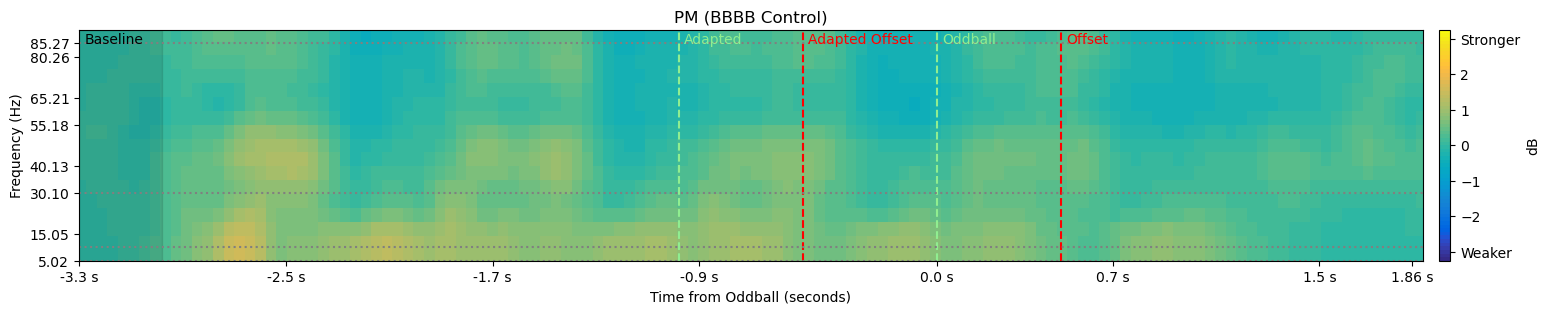

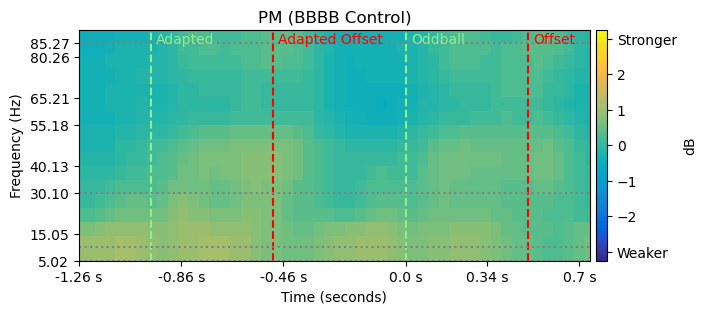

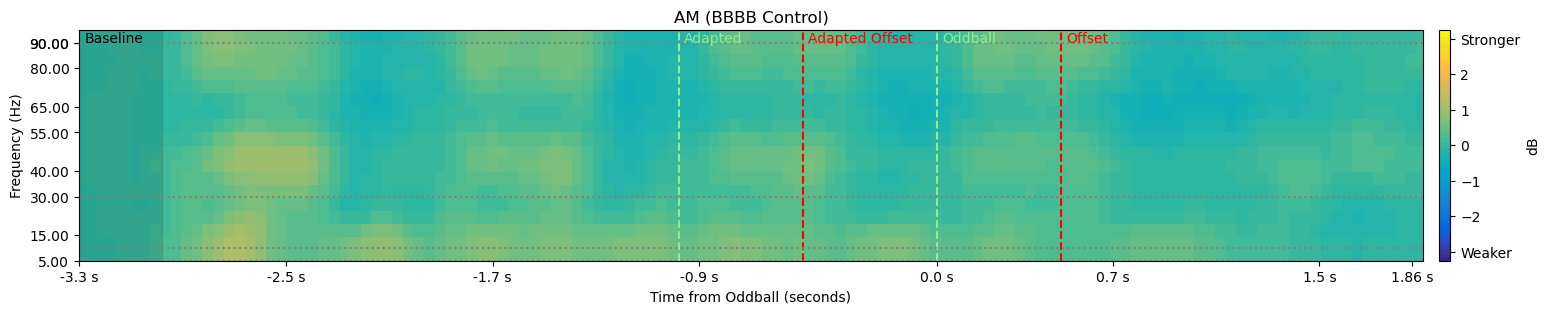

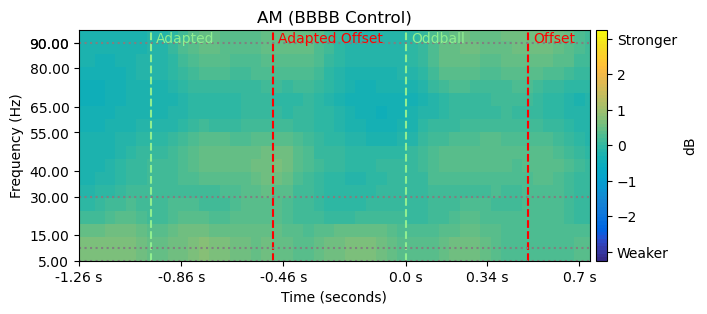

In [15]:
for cond in CONDITIONS:
    cond_stattitle = functools.partial(condition_stattitle, cond)
    tfr_summaries[cond] = summaries[cond].results().smap(lambda sig: oscillatory_spectrogram(sig)).erp()
    tfrs = tfr_summaries[cond].smap(lambda tfr: tfr.baseline(-3.5 * pq.second, -3.0 * pq.second, decibels=True))
    tfrs.plot(signals=anatomical_areas, sigtitle=cond_stattitle, title="%s spectrograms by area" % cond, vmin=-3.25, vmax=3.25, baseline=(-3.5, -3.0),
              figure="oscillatory_spectrogram_downsample8_%s.pdf" % cond, **EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_spectrogram_downsample8_%s/" % cond, exist_ok=True)
        tfrs.signals[area].plot(title=cond_stattitle(area, tfrs.signals[area]), filename="oscillatory_spectrogram_downsample8_%s/%s.pdf" % (cond, area), vmin=-3.25, vmax=3.25,
                                baseline=(-3.5, -3.0), cbar_ends=("Stronger", "Weaker"), tlabel="Time from Oddball (seconds)", **EVENTS)
        oddball_signal = tfrs.signals[area][ADAPTED_ONSET.magnitude - 0.25:ODDBALL_OFFSET.magnitude + 0.25]
        oddball_signal.plot(title=cond_stattitle(area, tfrs.signals[area]), vmin=-3.25, vmax=3.25,
                                                 filename="oscillatory_spectrogram_downsample8_%s/%s_oddball.pdf" % (cond, area), cbar_ends=("Stronger", "Weaker"), **EVENTS)